# Download and process the Bay Area's street network

In [1]:
import os, zipfile, requests, pandas as pd, geopandas as gpd, osmnx as ox
ox.config(use_cache=True, log_console=True)

In [2]:
# point to the shapefile for counties
counties_shapefile_url = 'http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_county_500k.zip'

# identify bay area counties by fips code
bayarea = {'Alameda':'001',
           'Contra Costa':'013',
           'Marin':'041',
           'Napa':'055',
           'San Francisco':'075',
           'San Mateo':'081',
           'Santa Clara':'085',
           'Solano':'095',
           'Sonoma':'097'}

## Download and extract the counties shapefile if it doesn't already exist, then load it

To use OSMnx, we need a polygon of the Bay Area's nine counties. So, we'll download a shapefile from the census, extract our counties, and take the union to form a polygon. Also, project the polygon so we can calculate its area for density stats.

In [3]:
counties_shapefile_zip = counties_shapefile_url[counties_shapefile_url.rfind('/') + 1 :]
counties_shapefile_dir = counties_shapefile_zip[: counties_shapefile_zip.rfind('.zip')]
if not os.path.exists(counties_shapefile_dir):
    response = requests.get(counties_shapefile_url)
    with open(counties_shapefile_zip, 'wb') as f:
        f.write(response.content)
        with zipfile.ZipFile(counties_shapefile_zip, 'r') as zip_file:
            zip_file.extractall(counties_shapefile_dir)
    os.remove(counties_shapefile_zip)

In [4]:
counties = gpd.read_file(counties_shapefile_dir)
len(counties)

3233

In [5]:
# retain only those tracts that are in the bay area counties
mask = (counties['STATEFP'] == '06') & (counties['COUNTYFP'].isin(bayarea.values()))
gdf_bay = counties[mask]
len(gdf_bay)

9

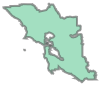

In [6]:
bayarea_polygon = gdf_bay.unary_union
bayarea_polygon

In [7]:
# get the convex hull, otherwise we'll cut out bridges over the bay
bayarea_polygon = bayarea_polygon.convex_hull
bayarea_polygon_proj, crs = ox.project_geometry(bayarea_polygon)

## Download the street network

Now we've got our polygon. Use OSMnx to download the street network (drivable roads).

In [8]:
# do not simplify yet, we'll strip out unwanted local streets first
G = ox.graph_from_polygon(bayarea_polygon, network_type='drive', simplify=False)

In [9]:
print(len(G.nodes()))
print(len(G.edges()))

1174424
2253232


In [10]:
G1 = G.copy()

In [11]:
# retain only the largest connected component subgraph, then simplify the graph
G1 = ox.remove_isolated_nodes(G1)
G1_connected = ox.get_largest_component(G1, strongly=False)
G1_simp = ox.simplify_graph(G1_connected, strict=True)
print(len(G1_simp.nodes()))
print(len(G1_simp.edges()))

221402
543724


## Filter the network to retain only tertiary streets and up

Including "unclassified" and "road" types as they often serve as null values.

In [12]:
G2 = G.copy()

In [13]:
# identify all the edge types we want to retain
types = ['motorway', 'motorway_link', 'trunk', 'trunk_link', 
         'primary', 'primary_link', 'secondary', 'secondary_link',
         'tertiary', 'tertiary_link', 'unclassified', 'road']

minor_streets = [(u, v, k) for u, v, k, d in G2.edges(keys=True, data=True) if d['highway'] not in types]

In [14]:
# remove minor streets, retain only the largest connected component subgraph, then simplify the graph
G2.remove_edges_from(minor_streets)
G2 = ox.remove_isolated_nodes(G2)
G2_connected = ox.get_largest_component(G2, strongly=False)
G2_simp = ox.simplify_graph(G2_connected, strict=True)
print(len(G2_simp.nodes()))
print(len(G2_simp.edges()))

31051
65257


## Filter the network to retain only secondary streets and up

Also discard "unclassified" and "road" types.

In [15]:
G3 = G.copy()

In [16]:
# identify all the edge types we want to retain
types = ['motorway', 'motorway_link', 'trunk', 'trunk_link', 
         'primary', 'primary_link', 'secondary', 'secondary_link']

minor_streets = [(u, v, k) for u, v, k, d in G3.edges(keys=True, data=True) if d['highway'] not in types]

In [17]:
# remove minor streets, retain only the largest connected component subgraph, then simplify the graph
G3.remove_edges_from(minor_streets)
G3 = ox.remove_isolated_nodes(G3)
G3_connected = ox.get_largest_component(G3, strongly=False)
G3_simp = ox.simplify_graph(G3_connected, strict=True)
print(len(G3_simp.nodes()))
print(len(G3_simp.edges()))

19452
35220


## Finally: calculate summary stats, save to disk

In [18]:
# save it as graphml to use in igraph and other network analysis tools
ox.save_graphml(G1_simp, filename='bayarea_full.graphml')
ox.save_graphml(G2_simp, filename='bayarea_tertiary.graphml')
ox.save_graphml(G3_simp, filename='bayarea_secondary.graphml')

See some stats on the coarsest network

In [19]:
pd.Series(ox.basic_stats(G3_simp, area=bayarea_polygon_proj.area))

circuity_avg                                                               1.08682
clean_intersection_count                                                      None
clean_intersection_density_km                                                 None
edge_density_km                                                            576.739
edge_length_avg                                                            449.335
edge_length_total                                                      1.58256e+07
intersection_count                                                           18275
intersection_density_km                                                   0.666004
k_avg                                                                      3.62122
m                                                                            35220
n                                                                            19452
node_density_km                                                           0.708898
self

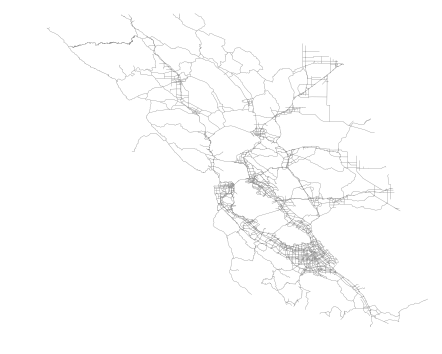

In [22]:
fig, ax = ox.plot_graph(G3_simp, node_size=0, edge_linewidth=0.2)

In [23]:
# save as shapefile for GIS
ox.save_graph_shapefile(G3_simp, filename='bayarea_secondary')